In [1]:
# USUAL Imports
import os
import pandas as pd
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from icecream import ic

In [2]:
# Having all of this Done, Reading the File, And Making a Data Frame

In [3]:
file_name = "data_set.csv"

df = pd.read_csv(file_name)
df = df.dropna()
df["tone"] = df["tone"].replace("Neative", "Negative")
df = df.drop_duplicates()
ic(df.head)
ic(df.shape)

ic| df.head: <bound method NDFrame.head of                                                comments      tone
             0     Mubashair to be bohat jald zalail ho ga shahid...  Negative
             1                                       Hahahhahhahaha    Neutral
             2                               Hum bi parh sakty hn na   Neutral
             3     Bharti Riyasat Mein Shadeed Barishon Ky Bais M...  Negative
             4     Imran khan koi prim manister nahi ha our na ko...   Neutral
             ...                                                 ...       ...
             4995  Zila Sergodha mein un dino Uninest parti ka ba...   Neutral
             4996  Mainy to sharefon wala kabhi react hi nai kra ...  Negative
             4997  Nora in AdyalaTeri baji IK k passFoj ko gaali ...  Negative
             4998   aur Newyork University se broadcasting ki khu...   Neutral
             4999               Uss ko khud zaroorat hai parhnay ki.  Negative
             
        

(4939, 2)

In [4]:
target = df.drop(columns=["tone"])  # X
test = df["tone"]  # y
encoder = LabelEncoder()
test = encoder.fit_transform(test)
categories = ["Positive", "Negative", "Neutral"]

# Convert 'target' and 'test' back to Pandas Series
target_series = pd.Series(target.values.squeeze())
test_series = pd.Series(test)

# Handle missing values (if any)
target_series.fillna(target_series.mode()[0], inplace=True)
test_series.fillna(test_series.mode()[0], inplace=True)

# Check the shapes of the input variables
ic(target_series.shape)
ic(test_series.shape)

# Ensure the number of samples is the same
if target_series.shape[0] != test_series.shape[0]:
    raise ValueError(
        "Number of samples in 'target_series' and 'test_series' is not the same."
    )

# Check for classes with only one member
unique_classes = pd.unique(test_series)
single_member_classes = [
    c for c in unique_classes if test_series.tolist().count(c) == 1
]

if single_member_classes:
    ic("Classes with only one member:", single_member_classes)
    # Remove the classes with only one member
    for c in single_member_classes:
        test_series.pop(test_series[test_series == c].index[0])

target_series.pop(target_series.index[0])
test_series.name = "tone"
target_series.name = "comments"

# Re-create the train-test split
target_train, target_test, test_train, test_test = train_test_split(
    target_series, test_series, stratify=test_series, random_state=0
)
ic("test_train", test_train)
ic("target_train", target_train)

ic| target_series.shape: (4939,)
ic| test_series.shape: (4939,)
ic| 'Classes with only one member:', single_member_classes: [3]
ic| "test_train": 'test_train'
    test_train: 2193    0
                3527    1
                1514    0
                1590    1
                484     2
                       ..
                4041    1
                3989    1
                4767    1
                4154    0
                3939    1
                Name: tone, Length: 3703, dtype: int64
ic| "target_train": 'target_train'
    target_train: 2194    Pakistan mein log Zia Mohyeddin ko television ...
                  3528                                          Subhanallah
                  1515                       Good afridi ham tumare sath ha
                  1591                         allah nazre bud se bechye ..
                  485                    yaha sakht londy bhi pighlty hain 
                                                ...                        
         

('target_train',
 2194    Pakistan mein log Zia Mohyeddin ko television ...
 3528                                          Subhanallah
 1515                       Good afridi ham tumare sath ha
 1591                         allah nazre bud se bechye ..
 485                    yaha sakht londy bhi pighlty hain 
                               ...                        
 4042                               Eye brow wali ye h na 
 3990                                  Iski taseer kesi h?
 4767                                          adhi raat 😂
 4155             fahad is best pasha ki to bat he alg thi
 3940     aap ne trust kiya mujh par, or chance diya mujhe
 Name: comments, Length: 3703, dtype: object)

In [5]:
# train and test dataframe
train_data = pd.merge(
    target_train.reset_index(drop=True),
    pd.DataFrame(test_train, columns=["tone"]),
    left_index=True,
    right_index=True,
)

test_data = pd.merge(
    target_test.reset_index(drop=True),
    pd.DataFrame(test_test, columns=["tone"]),
    left_index=True,
    right_index=True,
)

In [6]:
# Including Pre processing in the Code block Below
# corpus of words
# remove stopwords
# tokenize


from stopwords_urdu import STOPWORDS
import numpy as np


def create_meta_features(df):
    """This function creates meta features for EDA analysis"""

    # word count
    df["word_count"] = df["comments"].apply(lambda x: len(str(x).split()))
    # unique_word_count
    df["unique_word_count"] = df["comments"].apply(lambda x: len(set(str(x).split())))
    # stop_word_count
    df["stop_word_count"] = df["comments"].apply(
        lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS])
    )
    # mean_word_length
    df["mean_word_length"] = df["comments"].apply(
        lambda x: np.mean([len(w) for w in str(x).split()])
    )
    # char_count
    df["char_count"] = df["comments"].apply(lambda x: len(str(x)))
    # Some text are just the space character, which gives NaN values for mean_word_length
    df = df.fillna(0)  # Fill NaNs

    return df

In [7]:
main_df = create_meta_features(df)

/home/yeager/Music/fakesemantic/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yeager/Music/fakesemantic/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
# CORPUS and TF_IDF thinger
import re

# Need to Corpus of words


def make_corpus(target):
    corpus = []
    ic(len(target_train))
    for i in range(0, len(target_train)):
        review = re.sub("[^a-zA-Z]", " ", target_train.iloc[i])
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in STOPWORDS]
        review = " ".join(review)
        corpus.append(review)
    return corpus


corpus = make_corpus(target_train)

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
target_train_tfidf = tfidf_vectorizer.fit_transform(corpus)
# ic(dir(target_test))
# ic(target_test.to_list)
target_test_tfidf = tfidf_vectorizer.transform(target_test)
ic(target_train_tfidf, target_test_tfidf)

ic| len(target_train): 3703
ic| target_train_tfidf: <3703x11120 sparse matrix of type '<class 'numpy.float64'>'
                        	with 33498 stored elements in Compressed Sparse Row format>
    target_test_tfidf: <1235x11120 sparse matrix of type '<class 'numpy.float64'>'
                       	with 8939 stored elements in Compressed Sparse Row format>


(<3703x11120 sparse matrix of type '<class 'numpy.float64'>'
 	with 33498 stored elements in Compressed Sparse Row format>,
 <1235x11120 sparse matrix of type '<class 'numpy.float64'>'
 	with 8939 stored elements in Compressed Sparse Row format>)

In [9]:
# NAIVE BAYES
from evaluate import evaluate_model
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB


pipe = Pipeline([("smote", SMOTE(random_state=0)), ("nb", MultinomialNB())])
parameters = {"nb__alpha": [1]}
nb_classifier = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1)
nb_classifier.fit(target_train_tfidf, test_train)
ic(nb_classifier.best_estimator_)

ic| nb_classifier.best_estimator_: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                                   ('nb', MultinomialNB(alpha=1))])


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('nb', MultinomialNB(alpha=1))])

In [10]:
# EVALUATING THIS CLASSIFIER
evaluate_model(
    target_train_tfidf, test_train, target_test_tfidf, test_test, nb_classifier
)

ic| scorings: array([0.36356275, 0.3541329 , 0.34440843])
ic| model_score: 0.345748987854251
ic| accuracy: 0.345748987854251
ic| confusion: array([[ 84, 167,  74],
                      [147, 249, 150],
                      [ 99, 171,  94]])


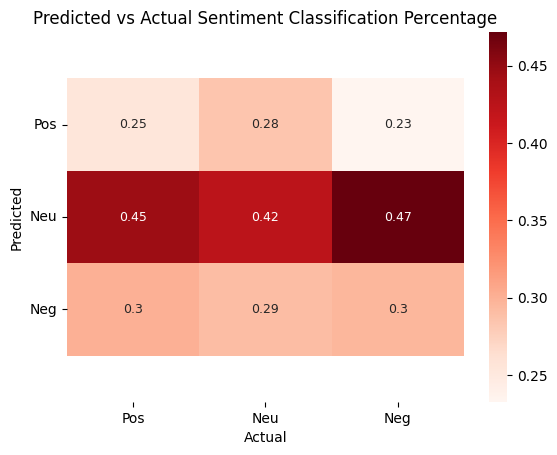

In [11]:
from evaluate import confusion_matrix_heatmap

confusion_matrix_heatmap(nb_classifier, target_test_tfidf, test_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(
    [("smote", SMOTE(random_state=0)), ("rf", RandomForestClassifier(random_state=0))]
)

parameters = {"rf__max_depth": [None], "rf__n_estimators": [100]}

rf_classifier = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1)
rf_classifier.fit(target_train_tfidf, test_train)
ic(rf_classifier.best_estimator_)

ic| rf_classifier.best_estimator_: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                                   ('rf', RandomForestClassifier(random_state=0))])


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('rf', RandomForestClassifier(random_state=0))])

In [13]:
evaluate_model(
    target_train_tfidf, test_train, target_test_tfidf, test_test, rf_classifier
)

ic| scorings: array([0.39757085, 0.39141005, 0.38006483])
ic| model_score: 0.3441295546558704
ic| accuracy: 0.3441295546558704
ic| confusion: array([[ 86, 191,  48],
                      [159, 273, 114],
                      [113, 185,  66]])


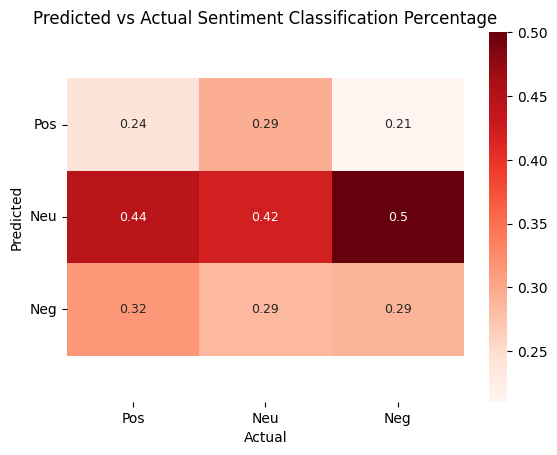

In [14]:
confusion_matrix_heatmap(rf_classifier, target_test_tfidf, test_test)

In [15]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    [
        ("smote", SMOTE(random_state=0)),
        ("log", LogisticRegression(random_state=0, max_iter=1000)),
    ]
)
parameters = {
    "log__C": [30],
    "log__penalty": ["l2"],
    "log__solver": ["saga"],
    "log__multi_class": ["auto"],
}

log_classifier = GridSearchCV(pipe, parameters, cv=3, n_jobs= -1)
log_classifier.fit(target_train_tfidf, test_train)
ic(log_classifier.best_estimator_)



ic| log_classifier.best_estimator_: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                                                    ('log',
                                                     LogisticRegression(C=30, max_iter=1000, random_state=0,
                                                                        solver='saga'))])


Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('log',
                 LogisticRegression(C=30, max_iter=1000, random_state=0,
                                    solver='saga'))])

In [16]:
evaluate_model(
    target_train_tfidf, test_train, target_test_tfidf, test_test, log_classifier
)

ic| scorings: array([0.34412955, 0.33711507, 0.34116694])
ic| model_score: 0.3287449392712551
ic| accuracy: 0.3287449392712551
ic| confusion: array([[ 96, 133,  96],
                      [163, 214, 169],
                      [113, 155,  96]])


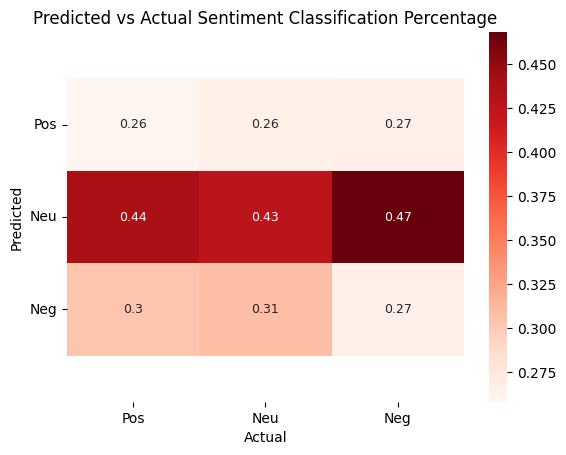

In [17]:
confusion_matrix_heatmap(log_classifier, target_test_tfidf, test_test)